In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import lightgbm as lightgbm
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [3]:
train = pd.read_csv("task2_allData.csv")
test_public = pd.read_csv("task2_public_test_data.csv")
test = pd.read_csv("task2_private_test_data.csv")

In [4]:
train = pd.merge(train, test_public, how = "outer")

In [5]:
x_train = train.drop(["AnswerValue", "AnswerId"], axis=1)
y_train = train.AnswerValue
x_test = test.drop(["AnswerValue", "AnswerId"], axis=1)
y_test = test.AnswerValue

In [6]:
categorical_features = ["UserId", "QuestionId", "QuizId", "GroupId", "SchemeOfWorkId",
                        "Gender", "PremiumPupil", "Confidence", "MathType", "SchoolShift"]

for feature in categorical_features:
    x_train[feature] = pd.Series(x_train[feature], dtype="category")
    x_test[feature] = pd.Series(x_test[feature], dtype="category")

In [7]:
params = {
    # "max_bin": [1500],
    "num_leaves": [600],
    "learning_rate": [0.1], # 0.15
    # "n_estimators": 600,
    "max_depth": [18],
    "n_jobs": [4],
    "verbose": [2]
}

In [8]:
model = lightgbm.LGBMClassifier(**params)
model.fit(x_train, y_train)

y_predict = model.predict(x_test)
print('private ', accuracy_score(y_test, y_predict))

[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.916341
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.184091
[LightGBM] [Debug] init for col-wise cost 0.257383 seconds, init for row-wise cost 1.099047 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.627225 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 58411
[LightGBM] [Info] Number of data points in the train set: 17851331, number of used features: 29
[LightGBM] [Info] Start training from score -1.422852
[LightGBM] [Info] Start training from score -1.340306
[LightGBM] [Info] Start training from score -1.329910
[LightGBM] [Info] Start training from score -1.457972
[LightGBM] [Debug] Trained a tree with leaves = 600 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 600 and

In [11]:
print(classification_report(y_test, y_predict, target_names=["A", "B", "C", "D"]))

              precision    recall  f1-score   support

           A       0.68      0.65      0.66    478895
           B       0.64      0.67      0.65    517881
           C       0.65      0.67      0.66    524238
           D       0.67      0.64      0.66    462468

    accuracy                           0.66   1983482
   macro avg       0.66      0.66      0.66   1983482
weighted avg       0.66      0.66      0.66   1983482



In [6]:
import pickle
pickle.dump(model, open("LightGBM.sav", 'wb'))

In [9]:
df = pd.DataFrame(y_predict, columns =['LightGBM'])
df.to_csv("LGBM2.csv", header=True, index=False)

In [30]:
df = pd.DataFrame(model.predict(x_test_public), columns =['Public'])
df.to_csv("LightGBM_Public.csv", header=True, index=False)
df = pd.DataFrame(model.predict(x_test_private), columns =['Private'])
df.to_csv("LightGBM_Private.csv", header=True, index=False)

In [9]:
featuresArray = []
for i in range(0, len(model.feature_name_)) :
    featuresArray.append([model.feature_name_[i], model.feature_importances_[i]])
    
df = pd.DataFrame(featuresArray, columns =['Feature Name', 'Feature Importance']).sort_values(by=["Feature Importance"], ascending=False)
dfSum = df["Feature Importance"].sum()
df["Feature Importance out of 100%"] = df["Feature Importance"].apply(lambda row: ((row / dfSum) * 100).round(3))
df

,Feature Name,Feature Importance,Feature Importance out of 100%
3,GroupId,56096,23.412
0,QuestionId,29891,12.475
2,QuizId,20392,8.511
9,IQLevel,19463,8.123
22,MinuteAnswered,14430,6.023
28,MathStdIQ,14076,5.875
14,TimeToAnswerQuiz,13963,5.828
25,#QuestionForStudent,12412,5.180
1,UserId,8243,3.440
15,QuestionDifficulty,7757,3.237


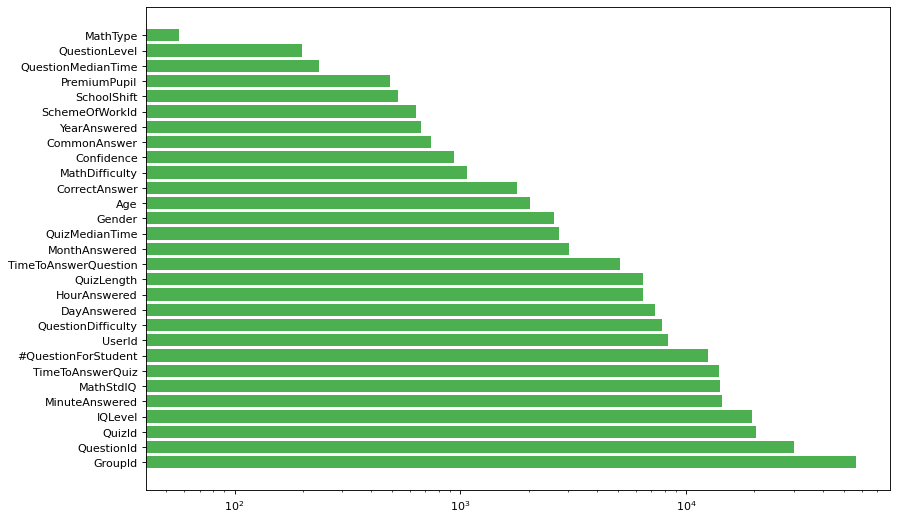

In [17]:
x = np.array(df["Feature Importance"])
y = np.array(df["Feature Name"])

figure(figsize=(12, 8), dpi=80)
plt.barh(y, x, color = "#4CAF50")
plt.xscale("log")
plt.show()